## Análisis no supervisado
### 1. Importación de librerías

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### 2. Carga del dataset original

In [3]:
df = pd.read_csv("../dataset/steam_dataset.csv")
df.shape

(1932, 25)

### 3. Selección de videojuegos y variables relevantes
#### 3.1 Filtrado solo a videojuegos

In [30]:
df_games = df[df["app_type"] == "Game"].copy()
df_games.shape

(1814, 25)

#### 3.2 Selección de variables para análisis no supervisado

Se han seleccionado variables que describen características funcionales y tecnológicas de lo sjuegos dentro del ecosistema Steam, evitando métricas de popularidad o rendimiento comercial. El objetivo es identificar tipologías de juego basadas en su perfil de plataformas, conectividad y servicios asociados, más que en su éxito relativo.

En concreto, se incluyeron variables relacionadas con la disponibilidad multiplataforma, modalidades multijugador, integracion con servicios de Steam (Workshop, Trading cards, estadísticas...) y compatibilidad con funcionalidades avanzadas como cloud gaming o juego remoto. Estas características reflejan el grado de complejidad técnica y el modelo de experiencia ofrecida al usuario.

La fecha de lanzamiento se incorporó como variable temporal para capturar posibles patrones asociados a la evolución tecnológica del catálogo, minetras que variables administrativas o de sistema fueron excluidas al no aportar información relevante sobre la tipología del producto. 

In [33]:
features_unsup = [
    "platforms",
    "multiplayer",
    "cross_platform_multiplayer",
    "steam_workshop",
    "steam_trading_cards",
    "in_app_purchases",
    "valve_anti_cheat",
    "cloud_gaming",
    "stats",
    "remote_play_on_phone",
    "remote_play_on_tablet",
    "release_date",
    "sys_date"
]

df_unsup = df_games[features_unsup].copy()
df_unsup.head()

,platforms,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,release_date,sys_date
0,Windows Linux,1,1,1,1,1,1,1,1,1,1,21 August 2012 – 17:00:00 UTC ( ),2025-10-25 17:18:37.331135
1,Windows macOS Linux,1,0,1,1,1,1,1,0,0,0,9 July 2013 – 17:00:00 UTC ( ),2025-10-25T17:20:37.052944
2,Windows,1,0,0,0,0,0,0,1,1,1,21 December 2017 – 08:05:00 UTC ( ),2025-10-25T17:20:47.425455
3,Windows,1,1,0,0,1,0,1,0,0,0,10 October 2025 – 14:58:00 UTC ( ),2025-10-25T17:20:56.481999
4,Windows macOS,0,0,1,1,0,0,1,0,0,0,16 October 2025 – 07:00:07 UTC ( ),2025-10-25T17:21:06.484682


### 4. Limpieza y transformación de variables
#### 4.1 Limpieza de la variable platforms
Se eliminan los valores nulos, y se codifica la variable original de manera sencilla y unificando los distintos nombres posibles, que se refieren a la misma plataforma.

In [34]:
df_unsup.dropna(subset=["platforms"], inplace=True)

platform_mapping = {
    "Windows": 1,
    "Windows macOS": 2,
    "macOS Windows": 2,
    "Windows Linux": 3,
    "Windows macOS Linux": 4,
    "macOS Windows Linux": 4
}

df_unsup["platform"] = df_unsup["platforms"].map(platform_mapping)
df_unsup.drop(columns=["platforms"], inplace=True)

#### 4.2 Procesamiento de fechas y antiguedad del juego
Se modifica el formato de la fecha del videojuego para calcular la antiguedad como meses desde que se publicó el videojuego.

In [35]:
# Limpieza del formato de release_date
df_unsup["release_date"] = (
    df_unsup["release_date"]
    .str.replace(r"\s*–\s*", " ", regex=True)
    .str.replace(r" UTC \( \)", "", regex=True)
    .str.strip()
)

df_unsup["release_date"] = pd.to_datetime(
    df_unsup["release_date"],
    format="%d %B %Y %H:%M:%S",
    errors="coerce"
)

# Parseo seguro de sys_date
def parse_date_safe(x):
    try:
        return pd.to_datetime(x, format="%Y-%m-%dT%H:%M:%S.%f")
    except:
        return pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f")

df_unsup["sys_date"] = df_unsup["sys_date"].apply(parse_date_safe)

# Cálculo de meses desde lanzamiento
df_unsup["months_since_release"] = (
    (df_unsup["sys_date"] - df_unsup["release_date"]).dt.days / 30
)

# Acotamos valores extremos
df_unsup["months_since_release"] = df_unsup["months_since_release"].clip(lower=1, upper=60)

df_unsup.drop(columns=["release_date", "sys_date"], inplace=True)

4.3 Eliminacion de filas con nulos

In [36]:
df_unsup.dropna(inplace=True)
df_unsup.shape

(1769, 12)

### 5. Escalado de variables

Dado que las variables seleccionadas presentan diferentes escalas y rangos de valores se deben estandarizar todas ellas para que todas tengan media cero y desviación estándar uno, evitando que aquellas con mayor rango o varianza numérica dominen el cálculo de distancias en los análisis posteriores. 

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_unsup)

In [41]:
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Varianza explicada por componente:", pca.explained_variance_ratio_)
print("Varianza total explicada:", pca.explained_variance_ratio_.sum())

Varianza explicada por componente: [0.18692003 0.13637505 0.13245443]
Varianza total explicada: 0.4557495101177591


Este análisis muestra que las tres primeras componentes concentran aproximadamente el 45,6% de la varianza total. Ningún componente domina claramente la varianza, lo que sugiere la ausencia de un único eje estructural que explique por sí solo las diferencias entre juegos, ya que el conjunto de datos analizado es bastante complejo.

Para visualizar cómo se reparten estas variables, se realiza un PCA

#### 6.2 Visualización PCA

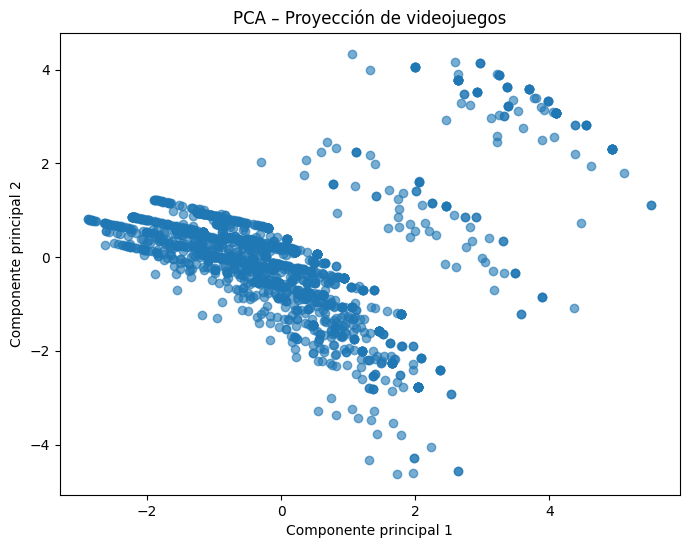

In [38]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.title("PCA – Proyección de videojuegos")
plt.show()

Este PCA sugiere la existencia de tres clústers diferenciados. Sin embargo, hay que probar distintas combinaciones de clústers para decidir si esta apariencia tiene un sustento estadístico claro detrás.


### 7. Elección del número de clústers

En primer lugar, se aplicó el método del codo sobre el algoritmo K-Means, evaluand valores de k entre 2 y 8 clústers. Se basa en al inercia, definida como la suma de distancias cuadráticas de cada observación a su centroide asignado, y porporciona una medida de la idoneidad de los clústers asignados.

El criterio del codo consiste en identificar un punto a paritr del cual el descenso de la inercia se ralentiza notablemente, indicando que añadir más clústers aporta mejoras marginales.

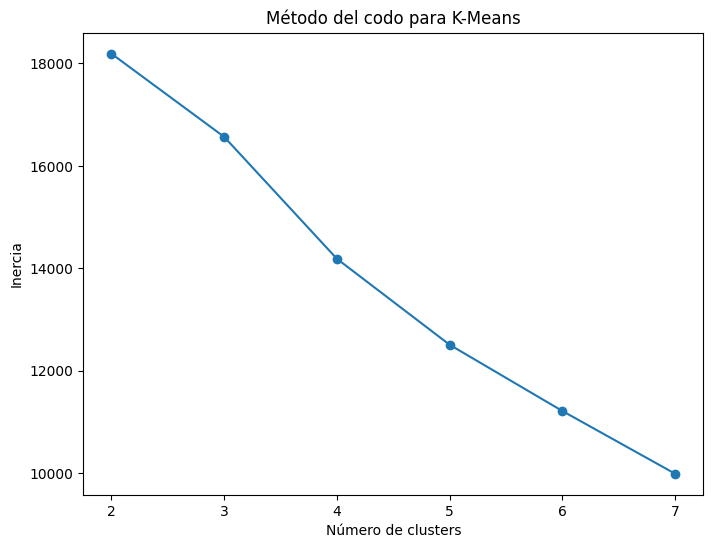

In [12]:
inertia = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K, inertia, marker="o")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.title("Método del codo para K-Means")
plt.show()

En este caso, la evolución de la inercia muestra una tendencia descendente más o menos lineal, sin un punto de inflexión claro. Sugiere que los datos no presentan una estructura fuertemente sesgada, sino una transición más bien gradual. Por tanto, se utilizó el índice silhouette para evaluar la calidad de los clústeres obtenidos con distintos valores de k. Este método valora lo cerca que esá cada punto de los de su propio clúster, y también lo lejos que está de los puntos del clúster alternativo más cercano. Con este doble criterio, se pueden apreciar mejores diferencias.

k=2, silhouette=0.327


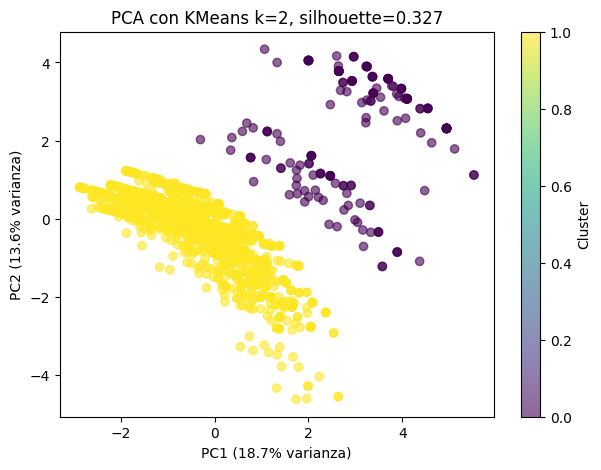

Medias de variables por cluster para k=2:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,-0.346375,-0.210063,-0.066216,0.339713,-0.220105,-0.065436,0.079698,-0.040417,2.370734,2.869028,0.340924,0.918458
1,0.039237,0.023796,0.007501,-0.038482,0.024933,0.007413,-0.009028,0.004578,-0.268554,-0.325000,-0.038619,-0.104042


k=3, silhouette=0.149


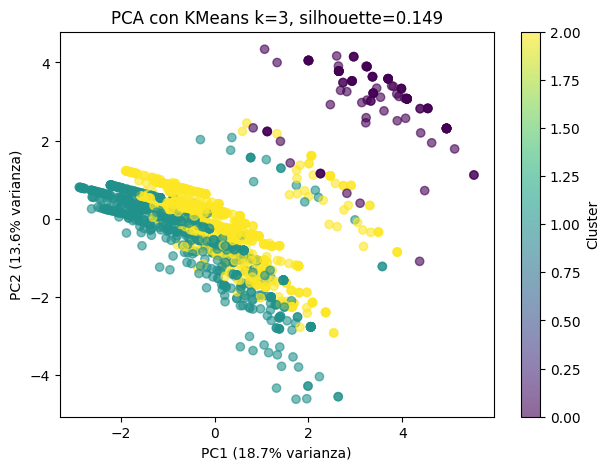

Medias de variables por cluster para k=3:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,-0.299251,-0.244648,-0.328244,0.280826,-0.230011,-0.025098,-0.007247,-0.025709,3.723647,2.762460,0.275521,0.933114
1,0.816195,0.442132,-0.008690,-0.022254,0.508242,0.169412,0.340030,-0.039601,-0.268554,-0.249697,-0.043995,0.049804
2,-0.670325,-0.351978,0.051854,-0.018512,-0.411518,-0.144129,-0.295103,0.037951,-0.268554,-0.155290,0.001135,-0.169263


k=4, silhouette=0.211


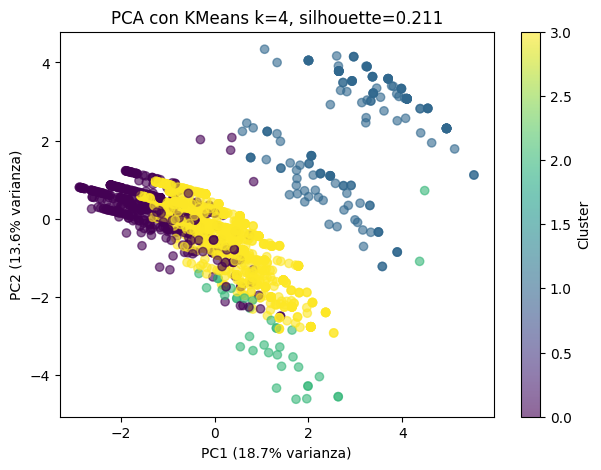

Medias de variables por cluster para k=4:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,0.568990,0.894774,-0.295208,-0.321008,1.447328,-0.144129,-0.303243,-0.019281,-0.268554,-0.295482,-0.158013,-0.130991
1,-0.386920,-0.278574,-0.068807,0.356136,-0.260754,-0.144129,0.080082,-0.061135,2.415857,2.861859,0.346109,0.915941
2,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850
3,-0.204773,-0.340345,0.107458,0.069804,-0.564170,-0.144129,0.106902,0.007974,-0.268554,-0.325000,-0.014304,-0.121196


k=5, silhouette=0.214


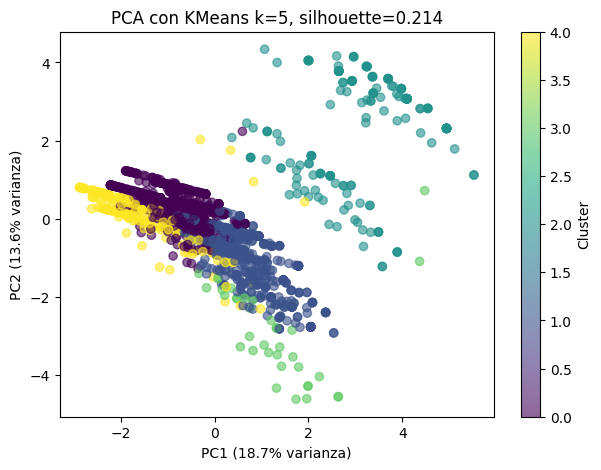

Medias de variables por cluster para k=5:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,-0.153183,-0.351978,-0.335348,-0.713143,0.033618,-0.144129,-0.284235,-0.044035,-0.268554,-0.320677,-0.327504,-0.523924
1,0.011290,-0.330403,0.508469,0.962142,-0.274994,-0.144129,0.430896,0.094432,-0.268554,-0.325000,0.275163,0.413391
2,-0.382188,-0.296606,-0.066650,0.351118,-0.245583,-0.144129,0.085943,-0.060198,2.431374,2.860616,0.329924,0.929759
3,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850
4,0.829444,2.841090,-0.307397,-0.433480,1.001179,-0.144129,-0.302474,-0.119362,-0.268554,-0.249819,0.052186,-0.151019


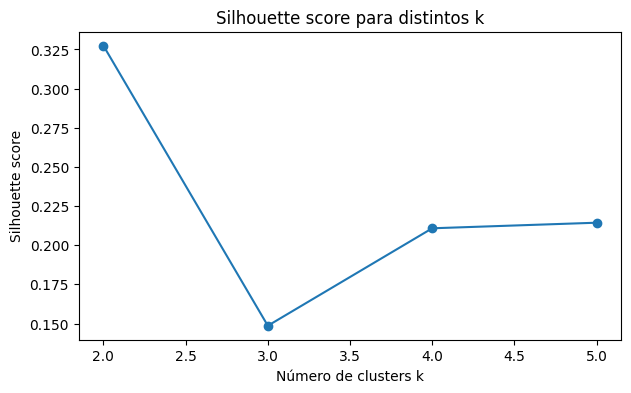

In [15]:
# --- Definir k para probar ---
k_values = list(range(2, 6)) # k pequeños y algunos grandes
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    
    # Silhouette score
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    print(f"k={k}, silhouette={sil:.3f}")
    
    # Scatter PCA con clusters coloreados
    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', alpha=0.6)
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)")
    plt.title(f"PCA con KMeans k={k}, silhouette={sil:.3f}")
    plt.colorbar(label="Cluster")
    plt.show()
    
    # Medias de variables por cluster
    df_scaled = pd.DataFrame(X_scaled, columns=df_unsup.columns)
    df_scaled['cluster'] = labels
    print(f"Medias de variables por cluster para k={k}:")
    display(df_scaled.groupby('cluster').mean())

# --- Gráfico resumen de silhouette ---
plt.figure(figsize=(7,4))
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("Número de clusters k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score para distintos k")
plt.show()

Los valores del silhouette score, junto con su representación en el PCA, llevaron a observar que la separación más adecuada de los grupos era probablemente en dos clústers. Con esto, se construyó el modelo final.

### Clustering con K-Means
#### 8.1 Model final

Con esta decisión de usar dos clusters, se prepara el modelo final, fijando k = 2. Una vez ajustado el modelo, a cada videojuego se le asinga una etiqueta de clúser en función a su proximidad al centroide correspondiente. Así, se pueden interpretar mejor los datos en posteriores gráficas.


In [16]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df_unsup["cluster"] = clusters
df_unsup.head()

,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release,cluster
0,1,1,1,1,1,1,1,1,1,1,3,60.0,0
1,1,0,1,1,1,1,1,0,0,0,4,60.0,1
2,1,0,0,0,0,0,0,1,1,1,1,60.0,0
3,1,1,0,0,1,0,1,0,0,0,1,1.0,1
4,0,0,1,1,0,0,1,0,0,0,2,1.0,1


8.2 Visualización de clusters en PCA

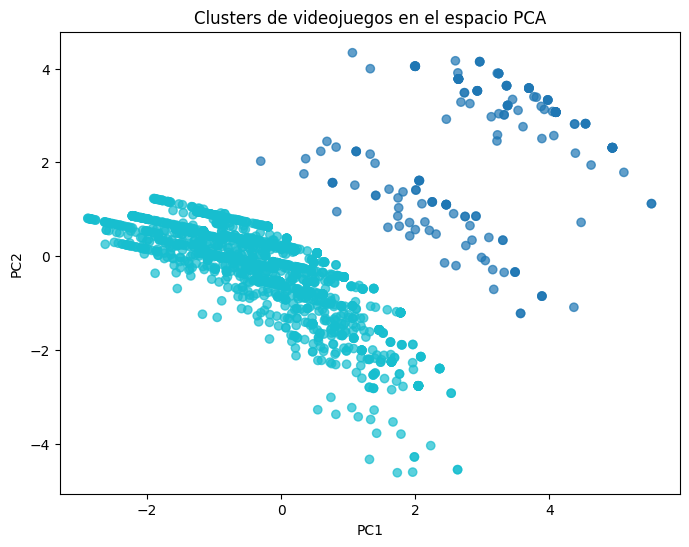

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=clusters,
    cmap="tab10",
    alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters de videojuegos en el espacio PCA")
plt.show()

En el PCA se puede apreciar que lo que parecía una división clara en tres clúster, se ha convertido en dos únicamente.

### 9. Interpretación de cada cluster
#### 9.1 Perfil medio de cada cluster

En la siguiente tabla se puede apreciar la relación de cada variable con cada clúster en detalle.

In [18]:
cluster_summary = df_unsup.groupby("cluster").mean()
cluster_summary

,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,0.422222,0.044444,0.138889,0.566667,0.155556,0.011111,0.505556,0.038889,0.661111,0.938889,1.994444,58.321296
1,0.611705,0.117684,0.166142,0.381372,0.261800,0.021397,0.461296,0.048458,0.000000,0.000000,1.587791,34.812314


### 10. Relación con la valoración del videojuego
En la siguiente gráfica se puede apreciar la diferencia de valoración media entre clústers.

In [19]:
df_unsup["high_rating"] = df_games.loc[df_unsup.index, "positive_reviews_per"] > 80
df_unsup.groupby("cluster")["high_rating"].mean()

cluster
0    0.861111
1    0.667086
Name: high_rating, dtype: float64

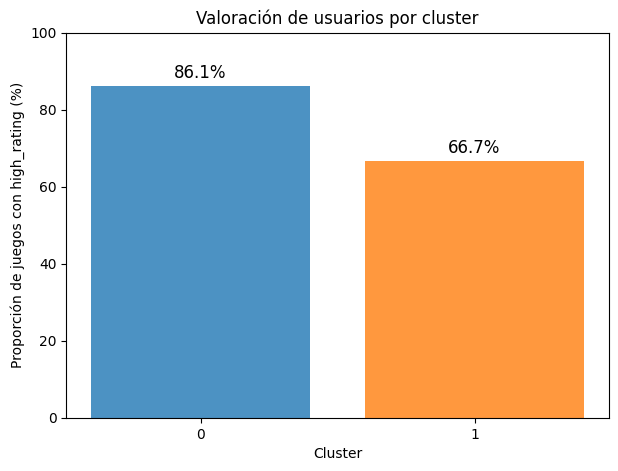

In [23]:
# Calcular proporción de high_rating por cluster
high_rating_perc = df_unsup.groupby("cluster")["high_rating"].mean() * 100

# Gráfico de barras
plt.figure(figsize=(7,5))
bars = plt.bar(
    high_rating_perc.index.astype(str),
    high_rating_perc.values,
    color=["#1f77b4", "#ff7f0e"],
    alpha=0.8
)

# Etiquetas de porcentaje encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 1,
        f"{height:.1f}%",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.xlabel("Cluster")
plt.ylabel("Proporción de juegos con high_rating (%)")
plt.title("Valoración de usuarios por cluster")
plt.ylim(0, 100)
plt.show()

A pesar de no ser enorme, se puede visualizar una preferencia por los videojuegos del clúster 1.

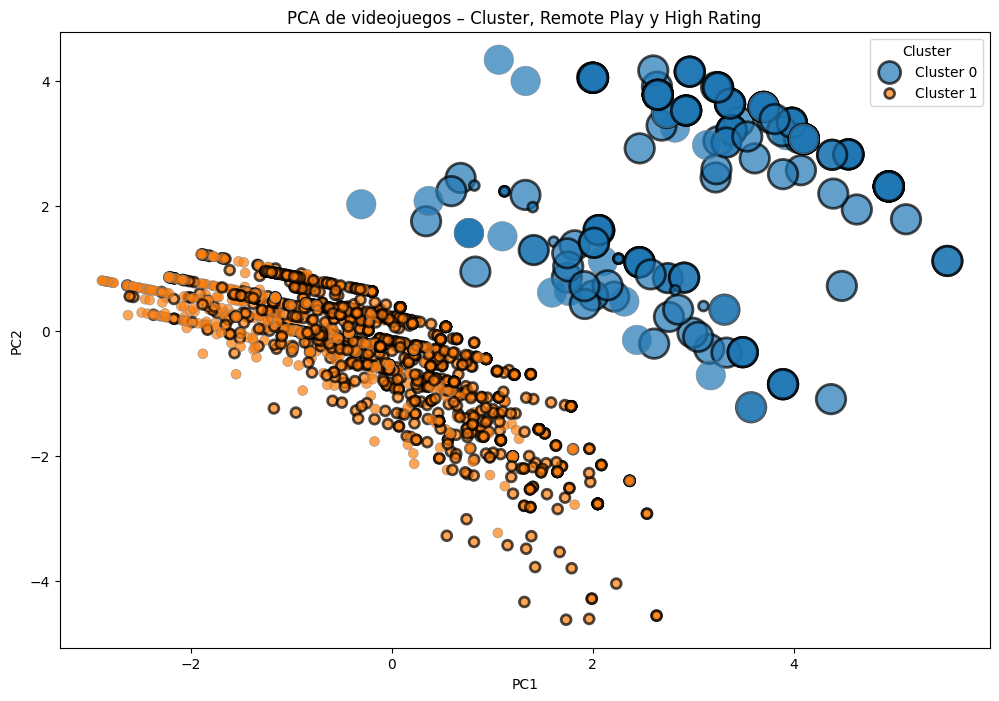

In [25]:
plt.figure(figsize=(12,8))

# Colores por cluster
cluster_colors = ["#1f77b4", "#ff7f0e"]

for i, color in enumerate(cluster_colors):
    idx = df_unsup["cluster"] == i
    # Determinar borde según high_rating
    edge_colors = df_unsup.loc[idx, "high_rating"].map({True: 'black', False: 'gray'})
    linewidths = df_unsup.loc[idx, "high_rating"].map({True: 2, False: 0.5})
    
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        c=color,
        s=50 + 400*df_unsup.loc[idx, "remote_play_on_tablet"],  # tamaño por remote play
        alpha=0.7,
        edgecolor=edge_colors,
        linewidths=linewidths,
        label=f"Cluster {i}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA de videojuegos – Cluster, Remote Play y High Rating")
plt.legend(title="Cluster")
plt.show()

Finalmente, en este gráfico se pueden apreciar tres diferencias 